# Лабораторна робота No4. Дослiдження окремих блокiв та шарiв згорткових нейронних мереж

## Мета
Навчитись використовувати спецiальнi блоки для побудови та полiпшення архiтектур згорткових нейронних мереж, зрозумiти use case того чи iншого блока.

## Виконання роботи

1. Обрати фреймворк, задачу, датасет та просту архiтектуру CNN для виконання роботи.
2. Обрати 3 рiзних блока (шара) для модифiкацiї обраної архiтектури CNN зi списку:
    - Attention
    - Squeeze-Excitation
    - Spatial Transformer
    - Inception block
    - Pyramid
    - Dilated convolution
    - Pointwise Convolution
чи обрати iнший варiант зi [списку](https://paperswithcode.com/methods/category/image-model-blocks).
3. Імпорт залежностей

In [1]:
import tensorflow as tf
import numpy as np

from src.data.util.dataset_util import extract_xy
from src.data.image_net import create_image_net_data_generator
from src.visualization.plot import (
    plot_loss_and_val_accuracy,
    plot_loss_and_val_loss,
    plot_confusion_matrix_heatmap,
)
from src.visualization.plot import plot_confusion_matrix_heatmap

from lib.model.vgg import (
    create_vgg_11,
    create_attention_vgg_11,
    create_squeeze_and_excitation_vgg_11,
    create_depthwise_separable_vgg_11,
)

Using TensorFlow backend


4. Завантажити, виконати попередню обробку та роздiлити датасет на тренувальну, валiдацiйну та тестову вибiрки.

In [2]:
train_ds, val_ds, input_shape, num_classes = create_image_net_data_generator(256)

2024-11-10 00:26:30.723137: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-11-10 00:26:30.723155: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 96.00 GB
2024-11-10 00:26:30.723158: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 36.00 GB
2024-11-10 00:26:30.723187: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-10 00:26:30.723201: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### VGG

1. Реалізувати архітектуру NN

In [3]:
model = create_vgg_11(num_classes, input_shape)

model.summary()

opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)

model.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics=["accuracy"],
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 224, 224, 64)      256       
 Normalization)                                                  
                                                                 
 elu (ELU)                   (None, 224, 224, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 128)     5

2. Навчити побудованi мережi на завантаженому датасетi. Дуже рекомендується навчати моделi на GPU.

In [4]:
train_feedback = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
)

print("Test loss: " + str(train_feedback.history["val_loss"][-1]))
print("Test accuracy: " + str(train_feedback.history["val_accuracy"][-1]))

Epoch 1/10


2024-11-09 01:11:58.177401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - 216s 6s/step - loss: 26.8547 - accuracy: 0.1778 - val_loss: 39.2429 - val_accuracy: 0.1613
Epoch 2/10
37/37 [==============================] - 218s 6s/step - loss: 2.1066 - accuracy: 0.3300 - val_loss: 7.1556 - val_accuracy: 0.1720
Epoch 3/10
37/37 [==============================] - 216s 6s/step - loss: 1.5053 - accuracy: 0.4852 - val_loss: 3.7554 - val_accuracy: 0.1980
Epoch 4/10
37/37 [==============================] - 214s 6s/step - loss: 1.1119 - accuracy: 0.6161 - val_loss: 3.1091 - val_accuracy: 0.2451
Epoch 5/10
37/37 [==============================] - 220s 6s/step - loss: 0.8275 - accuracy: 0.7161 - val_loss: 3.3145 - val_accuracy: 0.2482
Epoch 6/10
37/37 [==============================] - 218s 6s/step - loss: 0.6834 - accuracy: 0.7630 - val_loss: 3.8277 - val_accuracy: 0.2527
Epoch 7/10
37/37 [==============================] - 224s 6s/step - loss: 0.6564 - accuracy: 0.7732 - val_loss: 3.2831 - val_accuracy: 0.2563
Epoch 8/10
37/37 [====

3. Побудувати графiки навчання (loss та точнiсть) мережi на тренувальнiй на валiдацiйнiй вибiрках. Проаналiзувати отриманi результати, виконати порiвняння моделей мiж собою та з моделлю з попередньої роботи, зробити висновки.

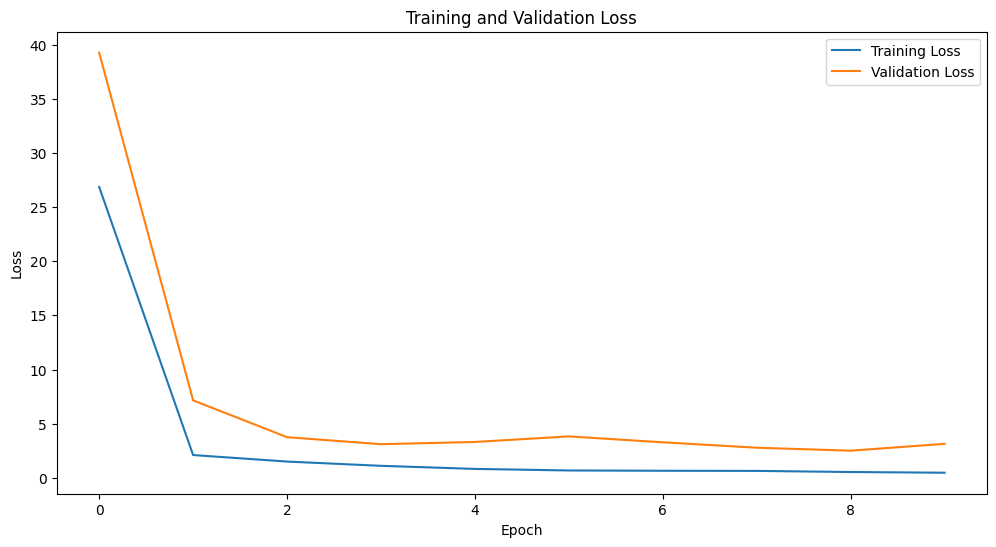

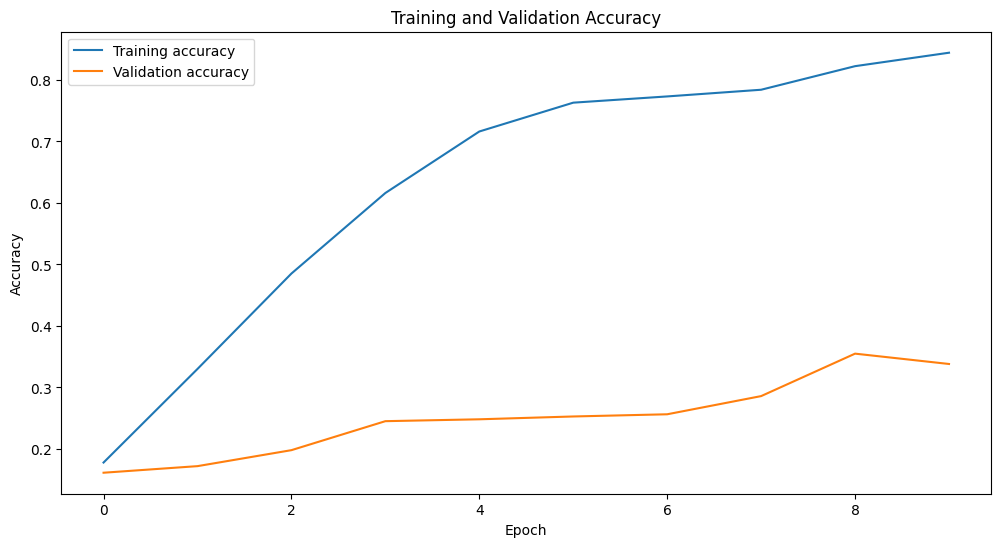

In [8]:
plot_loss_and_val_loss(train_feedback)
plot_loss_and_val_accuracy(train_feedback)

4. Побудувати матрицю невідповідностей

123/123 [==============================] - 15s 118ms/step


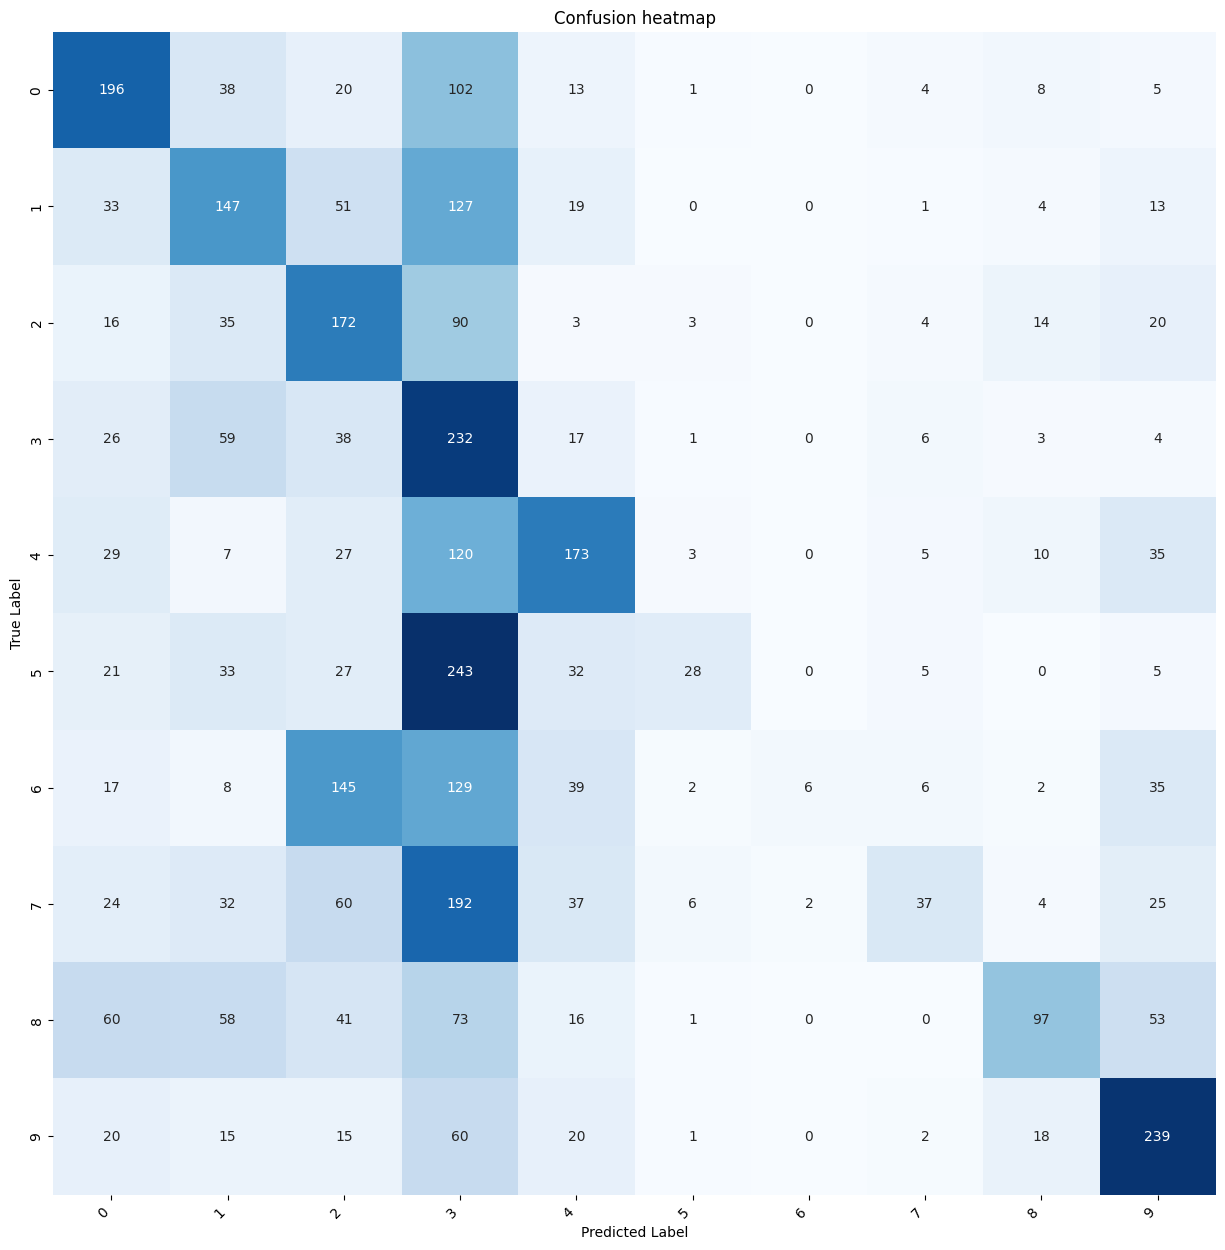

In [6]:
val_x, val_y = extract_xy(val_ds)
y_pred = np.argmax(model.predict(val_x), axis=1)

confusion = tf.math.confusion_matrix(val_y, y_pred)

plot_confusion_matrix_heatmap(confusion, np.arange(num_classes))

### VGG + Attention

1. Реалізувати архітектуру NN

In [5]:
model = create_attention_vgg_11(num_classes, input_shape)

model.summary()

opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)

model.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics=["accuracy"],
)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 224, 224, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_8 (Bat  (None, 224, 224, 64)         256       ['conv2d_8[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 elu_8 (ELU)                 (None, 224, 224, 64)         0         ['batch_normalization_8[

2. Навчити побудованi мережi на завантаженому датасетi. Дуже рекомендується навчати моделi на GPU.

In [6]:
train_feedback = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
)

print("Test loss: " + str(train_feedback.history["val_loss"][-1]))
print("Test accuracy: " + str(train_feedback.history["val_accuracy"][-1]))

Epoch 1/10
37/37 [==============================] - 226s 6s/step - loss: 5.2477 - accuracy: 0.3022 - val_loss: 2.9018 - val_accuracy: 0.2948
Epoch 2/10
37/37 [==============================] - 243s 7s/step - loss: 1.2715 - accuracy: 0.6107 - val_loss: 3.5791 - val_accuracy: 0.2683
Epoch 3/10
37/37 [==============================] - 253s 7s/step - loss: 0.6173 - accuracy: 0.7897 - val_loss: 3.5882 - val_accuracy: 0.3024
Epoch 4/10
37/37 [==============================] - 231s 6s/step - loss: 0.4607 - accuracy: 0.8448 - val_loss: 4.8050 - val_accuracy: 0.2961
Epoch 5/10
37/37 [==============================] - 229s 6s/step - loss: 0.3416 - accuracy: 0.8887 - val_loss: 3.7365 - val_accuracy: 0.3442
Epoch 6/10
37/37 [==============================] - 230s 6s/step - loss: 0.1630 - accuracy: 0.9443 - val_loss: 4.7742 - val_accuracy: 0.3460
Epoch 7/10
37/37 [==============================] - 229s 6s/step - loss: 0.0770 - accuracy: 0.9769 - val_loss: 3.4345 - val_accuracy: 0.4048
Epoch 8/10
37

3. Побудувати графiки навчання (loss та точнiсть) мережi на тренувальнiй на валiдацiйнiй вибiрках. Проаналiзувати отриманi результати, виконати порiвняння моделей мiж собою та з моделлю з попередньої роботи, зробити висновки.

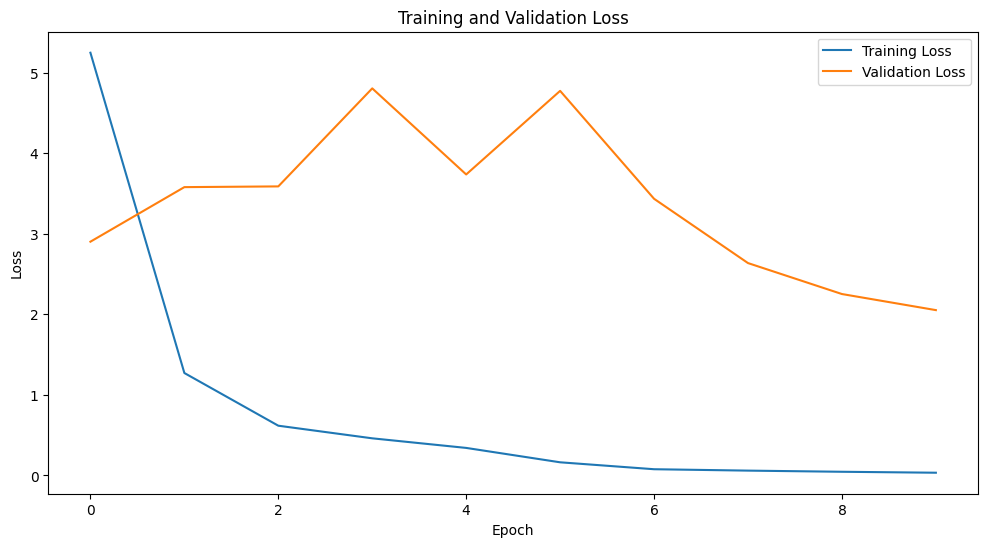

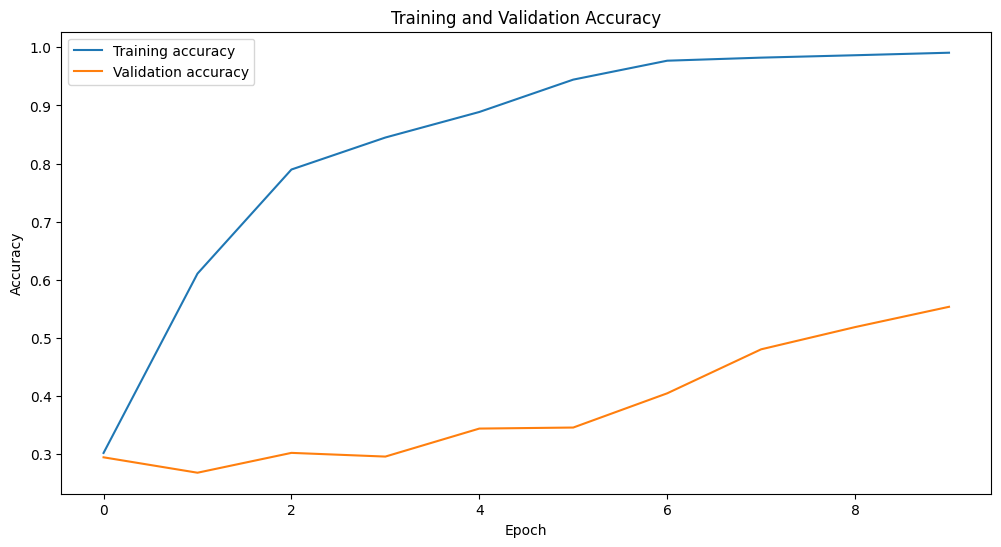

In [7]:
plot_loss_and_val_loss(train_feedback)
plot_loss_and_val_accuracy(train_feedback)

4. Побудувати матрицю невідповідностей

123/123 [==============================] - 16s 125ms/step


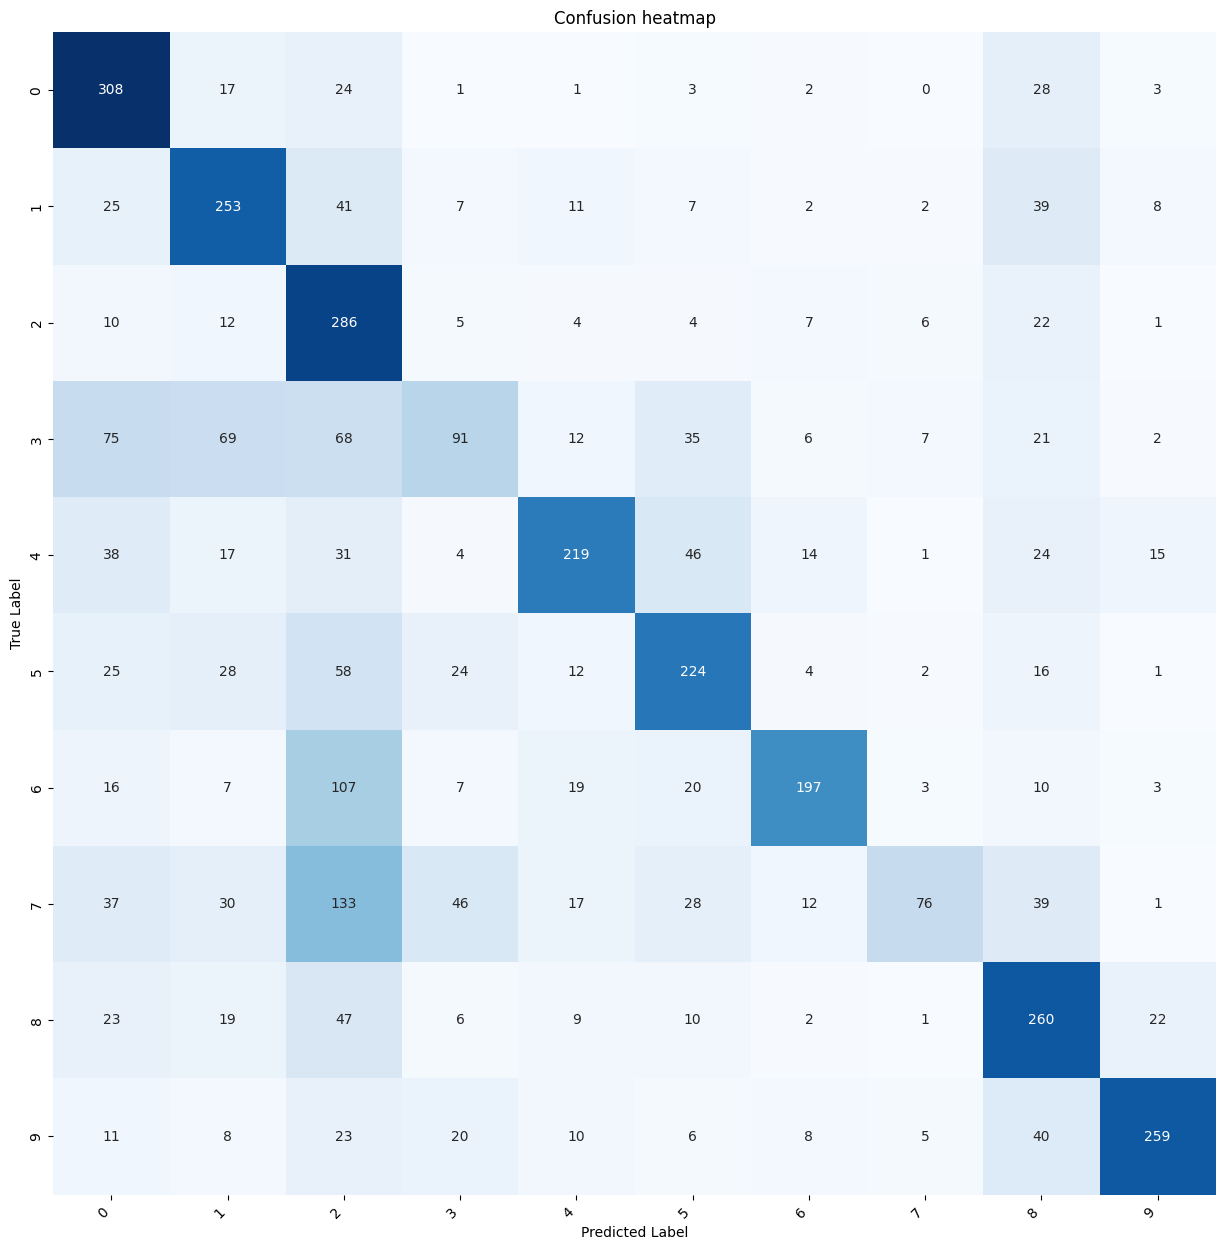

In [8]:
val_x, val_y = extract_xy(val_ds)
y_pred = np.argmax(model.predict(val_x), axis=1)

confusion = tf.math.confusion_matrix(val_y, y_pred)

plot_confusion_matrix_heatmap(confusion, np.arange(num_classes))

### VGG + Squeeze-and-Excitation

1. Реалізувати архітектуру NN

In [4]:
model = create_squeeze_and_excitation_vgg_11(num_classes, input_shape)

model.summary()

opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)

model.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics=["accuracy"],
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 224, 224, 64)      256       
 Normalization)                                                  
                                                                 
 elu (ELU)                   (None, 224, 224, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 squeeze_and_excite2d (Sque  (None, 112, 112, 64)      2128      
 ezeAndExcite2D)                                                 
                                                        

2. Навчити побудованi мережi на завантаженому датасетi. Дуже рекомендується навчати моделi на GPU.

In [5]:
train_feedback = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
)

print("Test loss: " + str(train_feedback.history["val_loss"][-1]))
print("Test accuracy: " + str(train_feedback.history["val_accuracy"][-1]))

Epoch 1/10


2024-11-09 20:52:16.092497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - 224s 6s/step - loss: 15.9097 - accuracy: 0.1653 - val_loss: 6.0655 - val_accuracy: 0.1694
Epoch 2/10
37/37 [==============================] - 246s 7s/step - loss: 2.1763 - accuracy: 0.2730 - val_loss: 2.6972 - val_accuracy: 0.2260
Epoch 3/10
37/37 [==============================] - 1367s 38s/step - loss: 1.8452 - accuracy: 0.3491 - val_loss: 2.4591 - val_accuracy: 0.2459
Epoch 4/10
37/37 [==============================] - 224s 6s/step - loss: 1.6429 - accuracy: 0.4114 - val_loss: 2.4160 - val_accuracy: 0.2538
Epoch 5/10
37/37 [==============================] - 234s 6s/step - loss: 1.4475 - accuracy: 0.4874 - val_loss: 2.4889 - val_accuracy: 0.2482
Epoch 6/10
37/37 [==============================] - 224s 6s/step - loss: 1.2373 - accuracy: 0.5591 - val_loss: 2.7271 - val_accuracy: 0.2492
Epoch 7/10
37/37 [==============================] - 224s 6s/step - loss: 1.0803 - accuracy: 0.6145 - val_loss: 2.4411 - val_accuracy: 0.3073
Epoch 8/10
37/37 [===

3. Побудувати графiки навчання (loss та точнiсть) мережi на тренувальнiй на валiдацiйнiй вибiрках. Проаналiзувати отриманi результати, виконати порiвняння моделей мiж собою та з моделлю з попередньої роботи, зробити висновки.

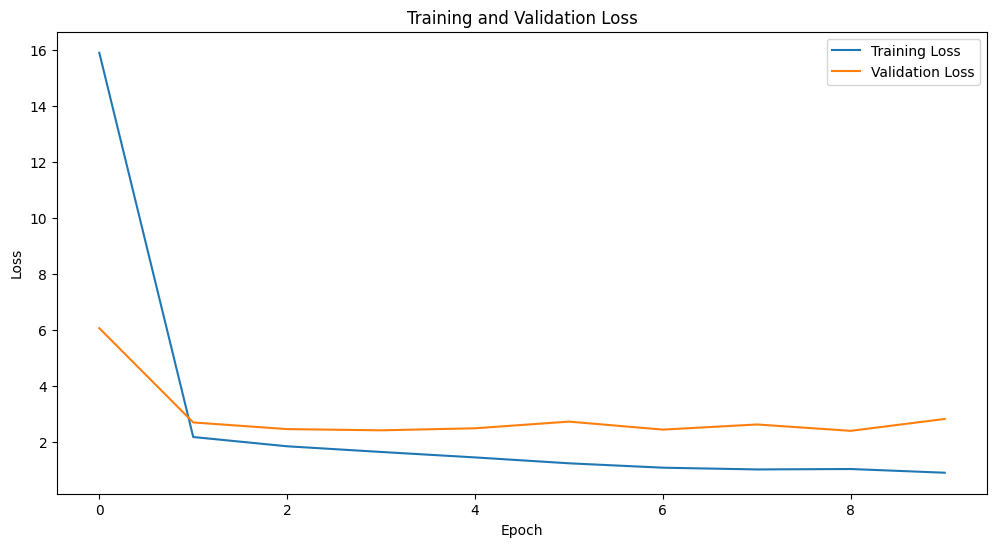

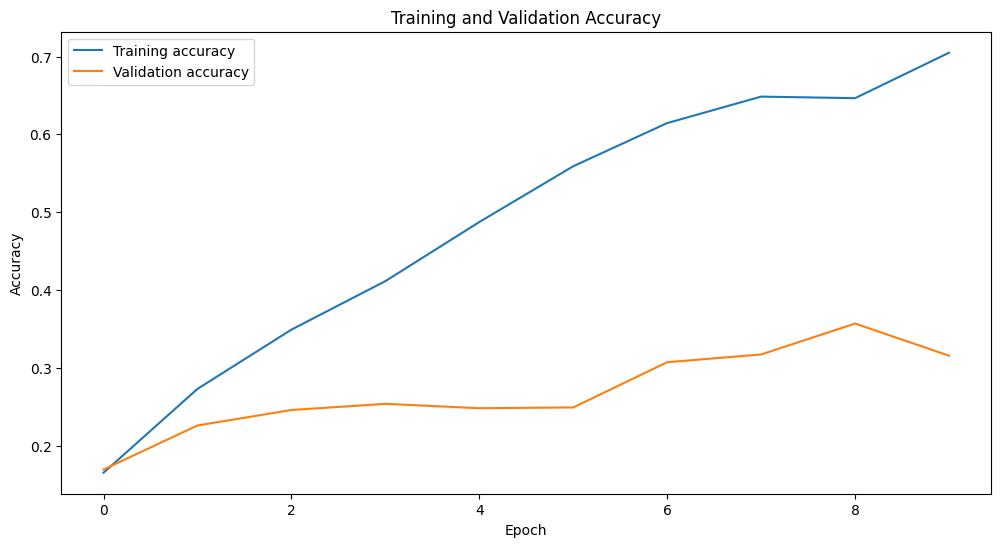

In [6]:
plot_loss_and_val_loss(train_feedback)
plot_loss_and_val_accuracy(train_feedback)

4. Побудувати матрицю невідповідностей

123/123 [==============================] - 17s 133ms/step


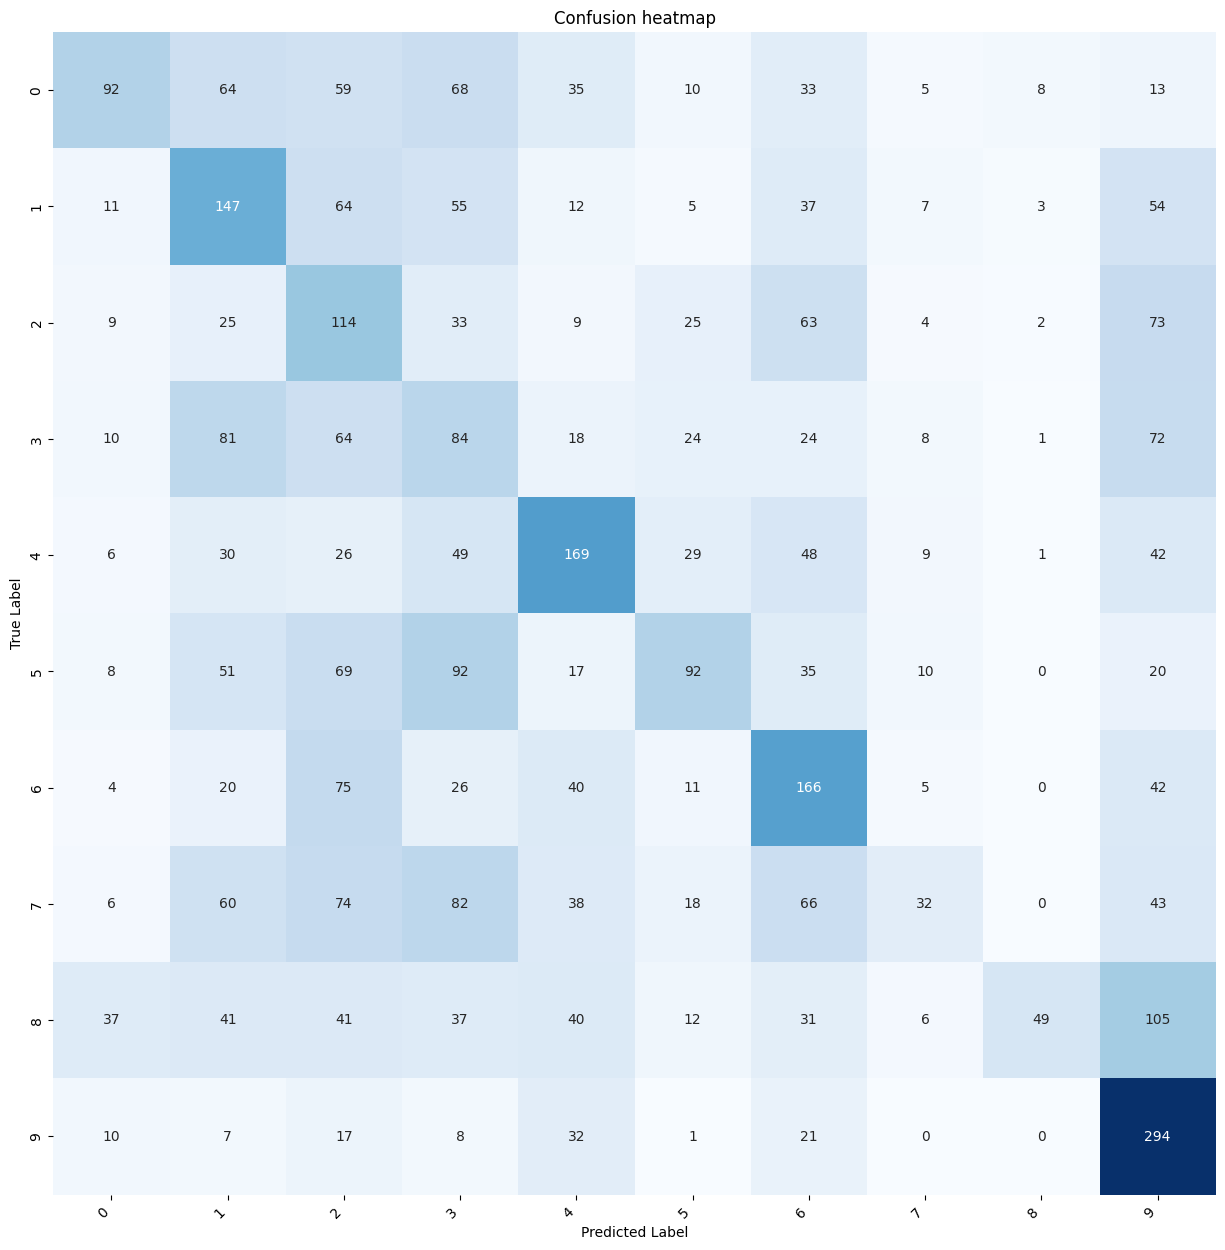

In [7]:
val_x, val_y = extract_xy(val_ds)
y_pred = np.argmax(model.predict(val_x), axis=1)

confusion = tf.math.confusion_matrix(val_y, y_pred)

plot_confusion_matrix_heatmap(confusion, np.arange(num_classes))

### VGG + Depthwise Separable Convolution

1. Реалізувати архітектуру NN

In [3]:
model = create_depthwise_separable_vgg_11(num_classes, input_shape)

model.summary()

opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)

model.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics=["accuracy"],
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv2d (Separabl  (None, 224, 224, 64)      283       
 eConv2D)                                                        
                                                                 
 batch_normalization (Batch  (None, 224, 224, 64)      256       
 Normalization)                                                  
                                                                 
 elu (ELU)                   (None, 224, 224, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 separable_conv2d_1 (Separa  (None, 112, 112, 128)     8896      
 bleConv2D)                                             

2. Навчити побудованi мережi на завантаженому датасетi. Дуже рекомендується навчати моделi на GPU.

In [4]:
train_feedback = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
)

print("Test loss: " + str(train_feedback.history["val_loss"][-1]))
print("Test accuracy: " + str(train_feedback.history["val_accuracy"][-1]))

Epoch 1/10


2024-11-10 00:26:46.052810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - 190s 5s/step - loss: 24.2452 - accuracy: 0.1961 - val_loss: 47.5927 - val_accuracy: 0.1017
Epoch 2/10
37/37 [==============================] - 201s 5s/step - loss: 1.9132 - accuracy: 0.3620 - val_loss: 45.8222 - val_accuracy: 0.1017
Epoch 3/10
37/37 [==============================] - 199s 5s/step - loss: 1.4707 - accuracy: 0.4937 - val_loss: 39.3597 - val_accuracy: 0.1017
Epoch 4/10
37/37 [==============================] - 201s 5s/step - loss: 1.1415 - accuracy: 0.5986 - val_loss: 31.4397 - val_accuracy: 0.1017
Epoch 5/10
37/37 [==============================] - 205s 5s/step - loss: 0.9302 - accuracy: 0.6725 - val_loss: 17.7924 - val_accuracy: 0.1009
Epoch 6/10
37/37 [==============================] - 205s 6s/step - loss: 0.8817 - accuracy: 0.6979 - val_loss: 10.6610 - val_accuracy: 0.0986
Epoch 7/10
37/37 [==============================] - 202s 5s/step - loss: 0.7775 - accuracy: 0.7370 - val_loss: 5.7819 - val_accuracy: 0.0983
Epoch 8/10
37/37 

3. Побудувати графiки навчання (loss та точнiсть) мережi на тренувальнiй на валiдацiйнiй вибiрках. Проаналiзувати отриманi результати, виконати порiвняння моделей мiж собою та з моделлю з попередньої роботи, зробити висновки.

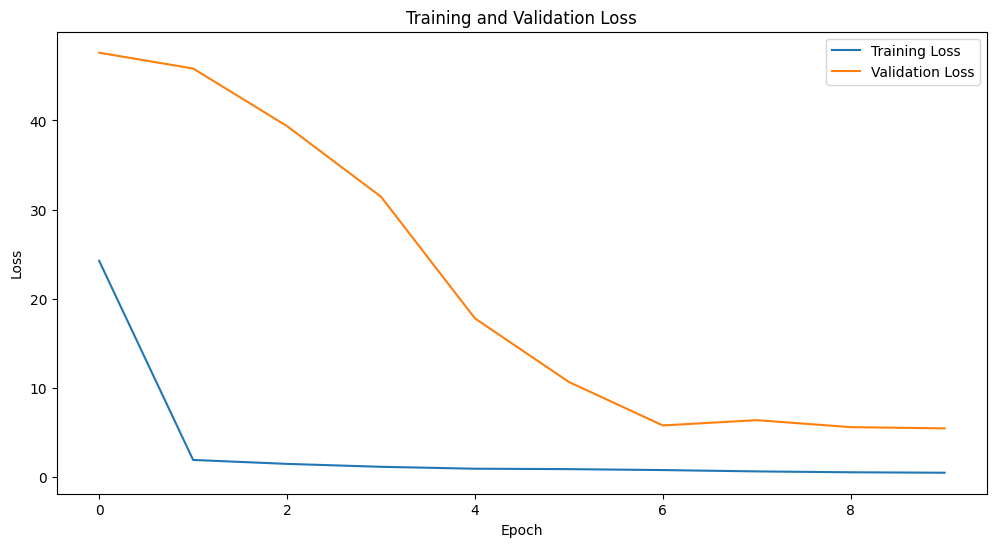

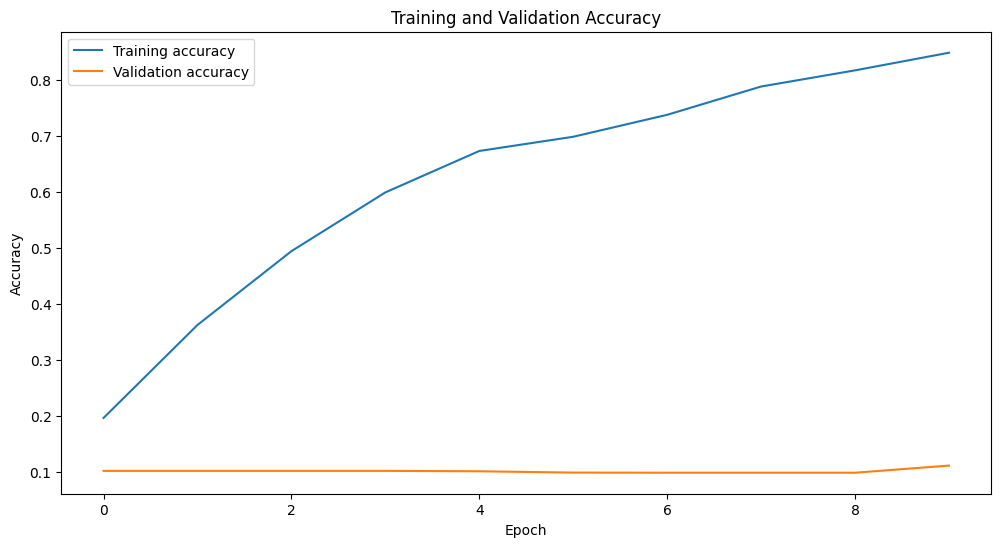

In [5]:
plot_loss_and_val_loss(train_feedback)
plot_loss_and_val_accuracy(train_feedback)

4. Побудувати матрицю невідповідностей

123/123 [==============================] - 12s 92ms/step


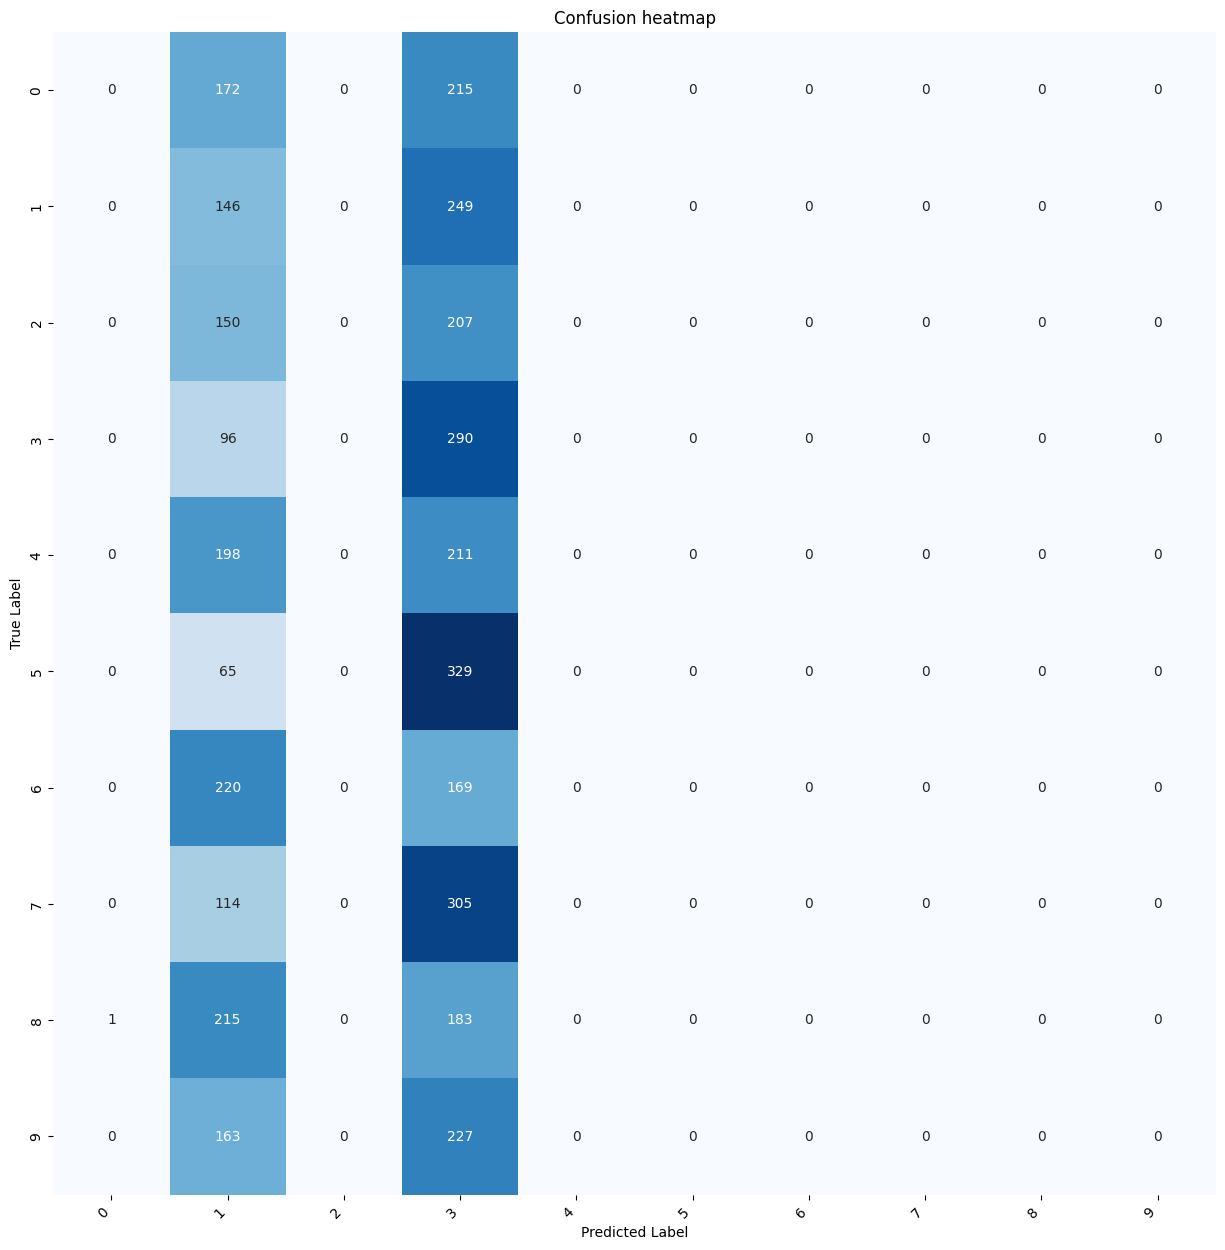

In [6]:
val_x, val_y = extract_xy(val_ds)
y_pred = np.argmax(model.predict(val_x), axis=1)

confusion = tf.math.confusion_matrix(val_y, y_pred)

plot_confusion_matrix_heatmap(confusion, np.arange(num_classes))